In [32]:
from pyspark.sql import SparkSession

# 创建 SparkSession
# Create SparkSession
spark = SparkSession.builder.appName("OnlineStoreBigDataAnalysis").getOrCreate()

# 读取电商数据 CSV 文件，自动推断字段类型并带有表头
# Read e-commerce data CSV file with header and infer schema automatically
df = spark.read.csv(
    "/Users/kk/Desktop/001/BigDataAnalysis/big_data_analysis/data/ecommerce_data.csv",
    header=True,         # 文件包含表头 / File contains header row
    inferSchema=True     # 自动推断字段类型 / Automatically infer schema
)

# 显示前 5 行数据
# Show the first 5 rows
df.show(5)

# 打印数据表结构（字段名、类型等）
# Print schema (column names, types, etc.)
df.printSchema()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |

In [33]:
from pyspark.sql.functions import col

# 删除缺失值和重复行
# Delete missing values and duplicate lines
df = df.dropna()
df = df.dropDuplicates()

# 转换数据类型
# Convert data types
df = df.withColumn("Quantity", col("Quantity").cast("float"))
df = df.withColumn("UnitPrice", col("UnitPrice").cast("float"))

# 计算订单金额
# Calculate the order amount
df = df.withColumn("order_amount", col("Quantity") * col("UnitPrice"))

# 查看前5行和表结构确认
# Check the first 5 rows and the table structure for confirmation
df.show(5)
df.printSchema()


+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|order_amount|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------+
|   536367|    22745|POPPY'S PLAYHOUSE...|     6.0| 12/1/2010 8:34|      2.1|     13047|United Kingdom|   12.599999|
|   536368|    22960|JAM MAKING SET WI...|     6.0| 12/1/2010 8:34|     4.25|     13047|United Kingdom|        25.5|
|   536388|    22915|ASSORTED BOTTLE T...|    12.0| 12/1/2010 9:59|     0.42|     16250|United Kingdom|        5.04|
|   536401|    21464|DISCO BALL ROTATO...|     1.0|12/1/2010 11:21|     4.25|     15862|United Kingdom|        4.25|
|   536412|    22569|FELTCRAFT CUSHION...|     2.0|12/1/2010 11:49|     3.75|     17920|United Kingdom|         7.5|
+---------+---------+--------------------+--------+-------------

In [34]:
from pyspark.sql.functions import month, sum as _sum, avg, count, when, to_timestamp

# 确保 InvoiceDate 是时间类型
# Ensure InvoiceDate is of timestamp type
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))

# 3.1 每月销售总额
# 3.1 Total monthly sales
df_monthly = df.withColumn("order_month", month("InvoiceDate"))
df_monthly.groupBy("order_month") \
    .agg(_sum("order_amount").alias("monthly_sales")) \
    .orderBy("order_month") \
    .show()

# 3.2 每类商品平均订单金额
# 3.2 Average order amount per product (by Description)
df.groupBy("Description") \
    .agg(avg("order_amount").alias("avg_order_amount")) \
    .show()

# 3.3 高价/低价订单量对比
# 3.3 Comparison of high/low unit price order volumes
df_promo = df.withColumn("promo_flag", when(df["UnitPrice"] > 5, 1).otherwise(0))
df_promo.groupBy("promo_flag") \
    .agg(count("InvoiceNo").alias("order_count")) \
    .show()

# 3.4 各国家订单数量统计
# 3.4 Order count statistics by country
df.groupBy("Country") \
    .count() \
    .show()


+-----------+------------------+
|order_month|     monthly_sales|
+-----------+------------------+
|          1| 473731.8985929936|
|          2|435534.06903989613|
|          3| 578576.2086951882|
|          4| 425222.6690814103|
|          5| 647011.6678886265|
|          6| 606862.5181514248|
|          7| 573112.3190384189|
|          8| 615078.0882323161|
|          9| 929356.2295153176|
|         10| 973306.3767381236|
|         11|1126815.0662214495|
|         12| 893912.2881904021|
+-----------+------------------+

+--------------------+------------------+
|         Description|  avg_order_amount|
+--------------------+------------------+
|SET/3 RED GINGHAM...| 27.80117137367661|
|PAPERWEIGHT KINGS...|10.323529530973996|
|MAGNETS PACK OF 4...| 6.533255633919738|
|SET/10 BLUE POLKA...|20.485237683052624|
|10 COLOUR SPACEBO...|20.275681453227996|
|POTTING SHED SOW ...|              4.25|
|GLASS CAKE COVER ...|               0.0|
|SILVER FABRIC MIRROR|  5.13741926224001|
|PINK  HO

+-------+-----------------+------------------+------------------+
|summary|        UnitPrice|          Quantity|      order_amount|
+-------+-----------------+------------------+------------------+
|  count|           401604|            401604|            401604|
|   mean|3.474063620379067|12.183272576966365| 20.61363781084244|
| stddev|69.76403508668506|250.28303714445406|430.35220066984505|
|    min|              0.0|          -80995.0|         -168469.6|
|    max|          38970.0|           80995.0|          168469.6|
+-------+-----------------+------------------+------------------+

Correlation between UnitPrice and Quantity: -0.0012434674707142697
t-test (High vs Low UnitPrice): 5.523899547745037 p-value: 3.317617281901098e-08


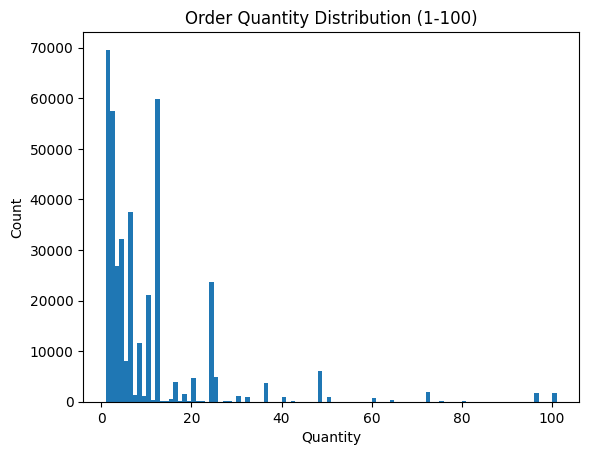

In [35]:
# 4.1 描述性统计
# 4.1 Descriptive Statistics
df.describe(["UnitPrice", "Quantity", "order_amount"]).show()

# 4.2 相关性分析
# 4.2 Correlation Analysis
correlation = df.stat.corr("UnitPrice", "Quantity")
print("Correlation between UnitPrice and Quantity:", correlation)

# 4.3 假设检验（高单价 vs 低单价订单金额）
# 4.3 Hypothesis Testing (High price vs low price order amounts)
high_price_pd = df.filter(df["UnitPrice"] > 5).select("order_amount").toPandas()
low_price_pd = df.filter(df["UnitPrice"] <= 5).select("order_amount").toPandas()

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(high_price_pd["order_amount"], low_price_pd["order_amount"])
print("t-test (High vs Low UnitPrice):", t_stat, "p-value:", p_val)

# 4.4 分布分析（销量分布直方图，过滤极端异常值，只显示1-100件的分布）
# 4.4 Distribution Analysis (Order Quantity Distribution Histogram, filter extreme outliers, only show 1-100)
quantity_pd = df.select("Quantity").toPandas()
filtered = quantity_pd[(quantity_pd["Quantity"] >= 1) & (quantity_pd["Quantity"] <= 100)]

import matplotlib.pyplot as plt
plt.hist(filtered["Quantity"], bins=range(1, 102))  # bins=1~101
plt.title("Order Quantity Distribution (1-100)")
plt.xlabel("Quantity")
plt.ylabel("Count")
plt.show()


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# 1. 类别特征编码
# 1. Category Feature Encoding
for colname in ["Description", "Country"]:
    indexer = StringIndexer(inputCol=colname, outputCol=colname + "_idx")
    df = indexer.fit(df).transform(df)

# 2. 标记高单价订单为1，否则为0
# 2. Mark high unit price order as 1, else 0 (example for binary label)
from pyspark.sql.functions import when
df = df.withColumn("label", when(df["UnitPrice"] > 5, 1).otherwise(0))

# 3. 组装特征向量
# 3. Assemble feature vector
assembler = VectorAssembler(
    inputCols=[
        "UnitPrice", "Quantity",           # 数值特征 Numeric features
        "Description_idx", "Country_idx"   # 编码后的类别特征 Encoded categorical features
    ],
    outputCol="features"
)
df_model = assembler.transform(df)

# 4. 划分训练集与测试集
# 4. Split train/test
train, test = df_model.randomSplit([0.7, 0.3], seed=2025)


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. 组装特征向量
# 1. Assemble feature vector 
assembler = VectorAssembler(
    inputCols=["Quantity", "Description_idx", "Country_idx"],
    outputCol="features"
)
df_model = assembler.transform(df)

# 2. 划分训练集与测试集
# 2. Split train and test set
train, test = df_model.randomSplit([0.7, 0.3], seed=2025)

# 3. 初始化并训练逻辑回归模型
# 3. Initialize and train Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_model = lr.fit(train)

# 4. 测试集预测
# 4. Predict on test set
predictions = lr_model.transform(test)

# 5. 评估模型AUC
# 5. Evaluate model AUC
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Logistic Regression AUC:", auc)


Logistic Regression AUC: 0.6810305370572556


+-----------+------+
|Country_idx|count |
+-----------+------+
|0.0        |356728|
|1.0        |9480  |
|2.0        |8475  |
|3.0        |7475  |
|4.0        |2528  |
|5.0        |2371  |
|6.0        |2069  |
|7.0        |1877  |
|8.0        |1471  |
|9.0        |1258  |
|10.0       |1086  |
|11.0       |803   |
|12.0       |757   |
|13.0       |695   |
|14.0       |611   |
|15.0       |461   |
|16.0       |401   |
|17.0       |389   |
|18.0       |358   |
|19.0       |341   |
|20.0       |291   |
|21.0       |247   |
|22.0       |241   |
|23.0       |229   |
|24.0       |182   |
|25.0       |151   |
|26.0       |146   |
|27.0       |127   |
|28.0       |68    |
|29.0       |61    |
|30.0       |58    |
|31.0       |45    |
|32.0       |35    |
|33.0       |32    |
|34.0       |30    |
|35.0       |17    |
|36.0       |10    |
+-----------+------+

Total samples: 401604, Country classes: 37
Max:Min class count ratio: 356728:10 = 35672.80
Random Forest multi-class classifier accuracy: 

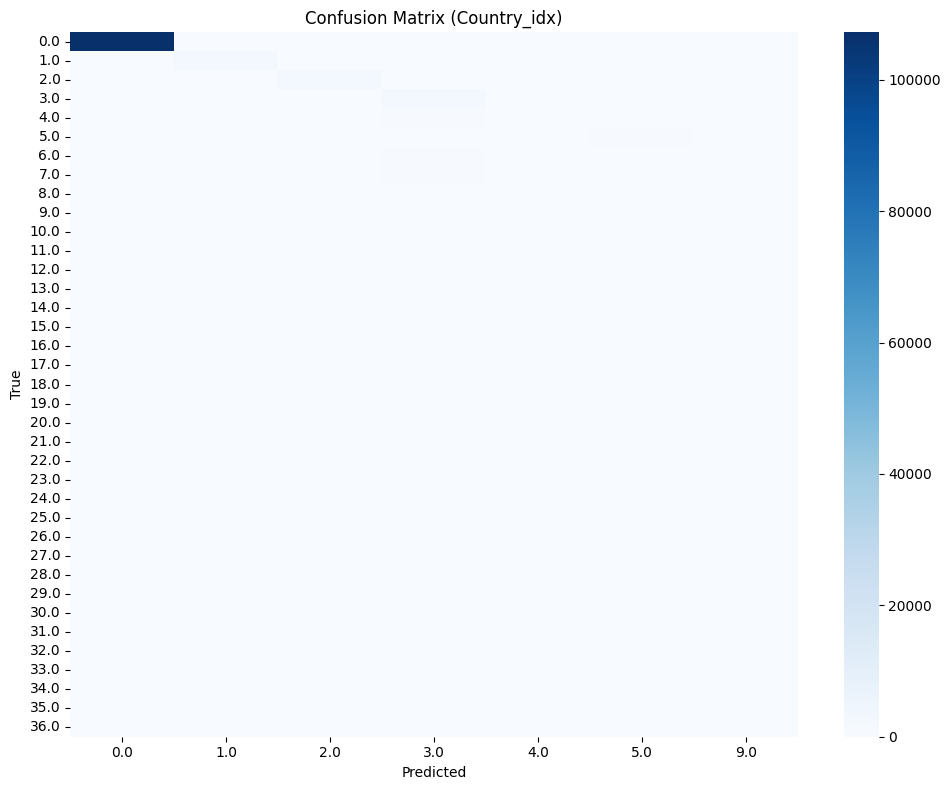

In [49]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

# 1. 组装特征向量
# 1. Assemble feature vector
assembler = VectorAssembler(
    inputCols=["UnitPrice", "Quantity", "Country_idx"],   # 数值特征和类别索引 Numeric features and categorical index
    outputCol="features"
)
df_model = assembler.transform(df)

# 2. 去除缺失值（防止训练和评估时报错）
# 2. Drop missing values (to avoid training/evaluation errors)
df_model = df_model.dropna(subset=["UnitPrice", "Quantity", "Country_idx"])

# 3. 检查各类别样本数量
# 3. Check sample size per class (label distribution)
country_dist = df_model.groupBy("Country_idx").count().orderBy(F.desc("count"))
country_dist.show(40, truncate=False)

# 打印总数、类别数量，计算最大/最小类别比例，提示样本分布
# Print total samples, class count, and ratio for class imbalance
total = df_model.count()
country_num = df_model.select("Country_idx").distinct().count()
max_count = country_dist.first()["count"]
min_count = country_dist.orderBy("count").first()["count"]
print(f"Total samples: {total}, Country classes: {country_num}")
print(f"Max:Min class count ratio: {max_count}:{min_count} = {max_count/min_count:.2f}")

# 4. 划分训练集和测试集
# 4. Split train and test sets
train, test = df_model.randomSplit([0.7, 0.3], seed=2025)

# 5. 初始化并训练随机森林模型
# 5. Initialize and train Random Forest model
rf = RandomForestClassifier(
    labelCol="Country_idx",
    featuresCol="features",
    numTrees=20,
    maxBins=max(128, country_num+10)  # maxBins建议设置比类别数量大 Some margin for maxBins
)
rf_model = rf.fit(train)

# 6. 预测
# 6. Predict on test set
rf_predictions = rf_model.transform(test)

# 7. 多种评估指标
# 7. Multiple evaluation metrics
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Country_idx", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Country_idx", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Country_idx", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Country_idx", predictionCol="prediction", metricName="weightedRecall")

accuracy = evaluator_acc.evaluate(rf_predictions)
f1 = evaluator_f1.evaluate(rf_predictions)
precision = evaluator_precision.evaluate(rf_predictions)
recall = evaluator_recall.evaluate(rf_predictions)

print(f"Random Forest multi-class classifier accuracy: {accuracy:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# 8. 混淆矩阵（类别数太多可不画）
# 8. Confusion matrix (skip drawing if too many classes)
cm_df = rf_predictions.groupBy("Country_idx", "prediction").count().orderBy("Country_idx", "prediction").toPandas()
if cm_df.shape[0] < 500:  # Only plot if number of class combinations is not too large
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    pivot_cm = cm_df.pivot(index='Country_idx', columns='prediction', values='count').fillna(0)
    plt.figure(figsize=(10,8))
    sns.heatmap(pivot_cm, annot=False, fmt=".0f", cmap="Blues")
    plt.title("Confusion Matrix (Country_idx)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
else:
    print("Too many classes, confusion matrix not shown.")


/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:28: UserWarning: Glyph 35746 (\N{CJK UNIFIED IDEOGRAPH-8BA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:28: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:28: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:28: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:28: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8

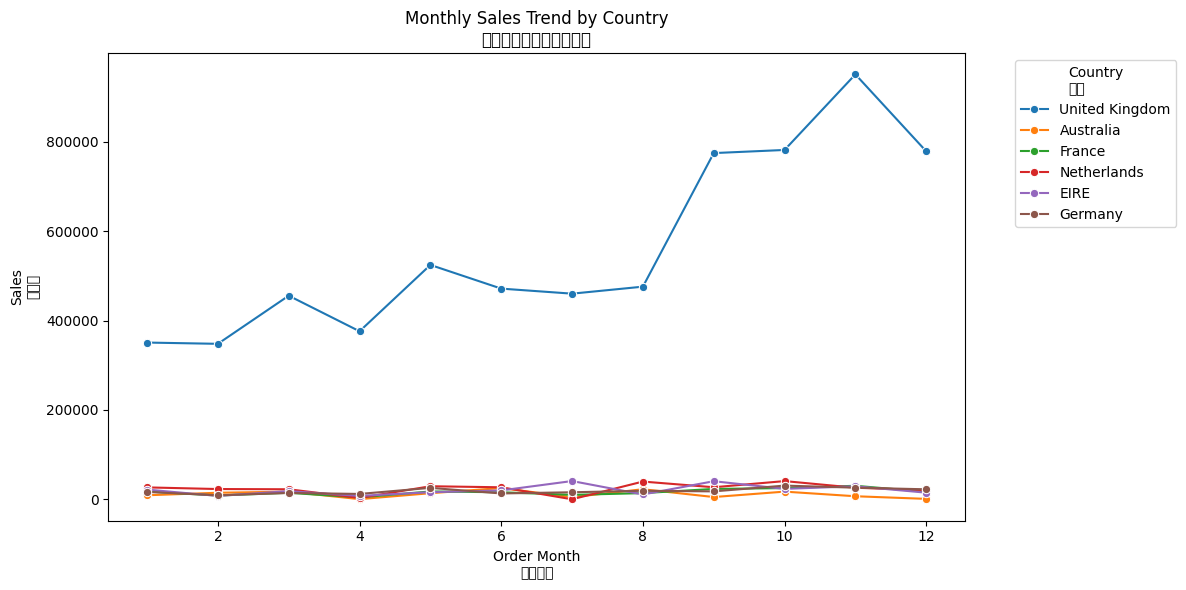

/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:39: UserWarning: Glyph 35746 (\N{CJK UNIFIED IDEOGRAPH-8BA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:39: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:39: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:39: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:39: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8

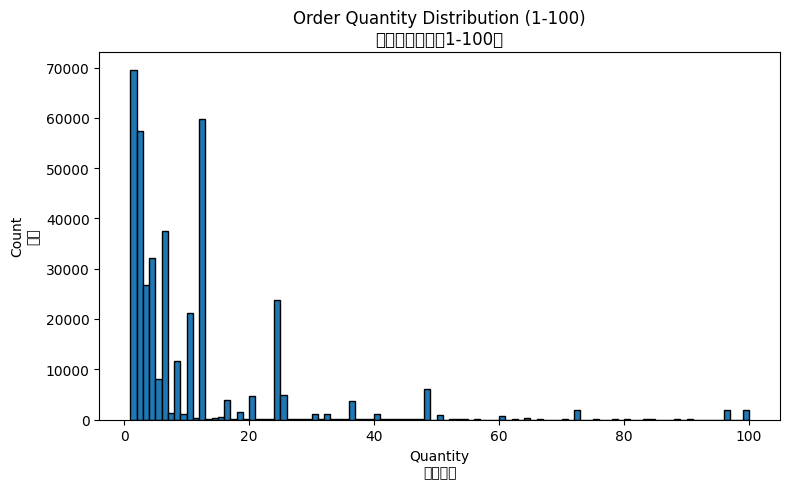

/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:55: UserWarning: Glyph 35746 (\N{CJK UNIFIED IDEOGRAPH-8BA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:55: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:55: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dg/k4r8ypfn4f7d72nqnwzn6lh40000gn/T/ipykernel_21622/3851893176.py:55: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRA

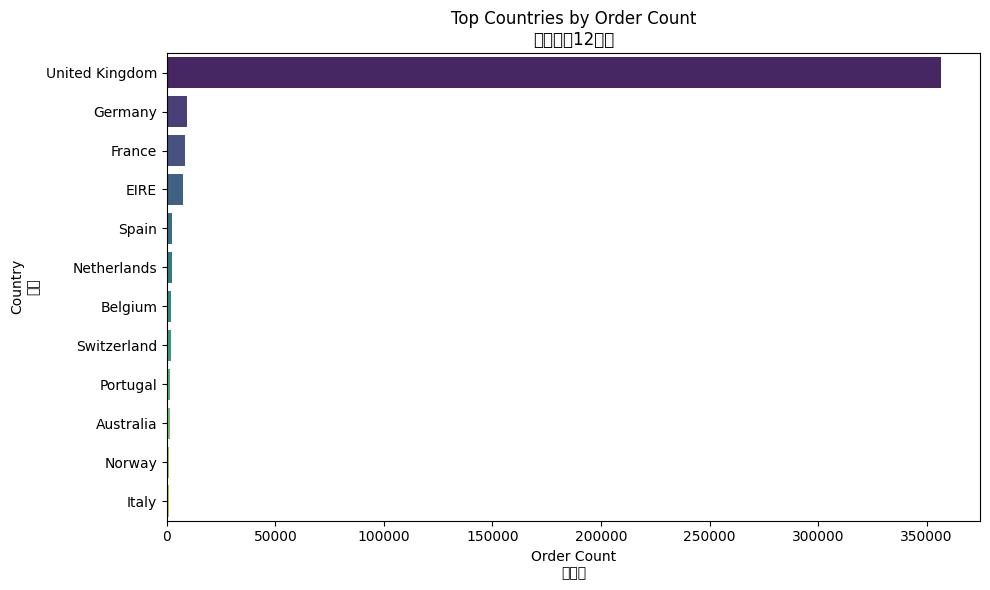

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import month, sum as _sum

# 1. 月销售额趋势（按国家分组）
# 1. Monthly Sales Trend by Country
monthly_sales_pd = (
    df.withColumn("order_month", month("InvoiceDate"))
      .groupBy("order_month", "Country")
      .agg(_sum("order_amount").alias("sales"))
      .toPandas()
)

plt.figure(figsize=(12, 6))
# 只画订单量最多的前6个国家，防止线太多太乱，可自行调整
top_countries = monthly_sales_pd.groupby("Country")["sales"].sum().sort_values(ascending=False).head(6).index
sns.lineplot(
    x="order_month",
    y="sales",
    hue="Country",
    data=monthly_sales_pd[monthly_sales_pd["Country"].isin(top_countries)],
    marker="o"
)
plt.title("Monthly Sales Trend by Country\n按国家分组的月销售趋势")
plt.xlabel("Order Month\n订单月份")
plt.ylabel("Sales\n销售额")
plt.legend(title="Country\n国家", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. 订单数量分布直方图（没有用户年龄则展示订单数量分布）
# 2. Order Quantity Distribution Histogram (if no user_age field)
quantity_pd = df.select("Quantity").toPandas()
plt.figure(figsize=(8, 5))
plt.hist(quantity_pd["Quantity"].dropna(), bins=range(1, 101), edgecolor="black")
plt.title("Order Quantity Distribution (1-100)\n订单数量分布（1-100）")
plt.xlabel("Quantity\n订单数量")
plt.ylabel("Count\n计数")
plt.tight_layout()
plt.show()

# 3. 各国家订单数柱状图（避免饼图文字重叠，可展示前10~15个）
# 3. Order Count by Country (Bar Chart, Top 10)
country_counts = df.groupBy("Country").count().toPandas().sort_values("count", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="count",
    y="Country",
    data=country_counts.head(12),
    palette="viridis"
)
plt.title("Top Countries by Order Count\n订单量前12国家")
plt.xlabel("Order Count\n订单数")
plt.ylabel("Country\n国家")
plt.tight_layout()
plt.show()
